In [1]:
%load_ext autoreload
%autoreload 2

import os,sys,inspect
# current_dir = '/home/jiayuand/seqOED_variational/examples/location'
# parent_dir = '/home/jiayuand/seqOED_variational'

# current_dir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
# parent_dir = os.path.dirname(os.path.dirname(current_dir))
parent_dir = '../../'
sys.path.insert(0, parent_dir) 

import numpy as np
# from scipy.stats import norm, beta, dirichlet
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from   torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
if torch.cuda.is_available():  
    dev = "cuda" 
else:  
    dev = "cpu"  
device = torch.device(dev) 
torch.set_default_device(device)
dtype = torch.float32
torch.set_default_dtype(dtype)

from vsOED import VSOED, PGvsOED, GMM_NET, NFs, POST_APPROX
from vsOED.utils import *
from vsOED.models import *

import dowel
import joblib

print('==============================================================================')
print('Please go to /home/<USER>/.local/lib/python3.9/site-packages/torch/storage.py')
print('and change def _load_from_bytes(b):')
print('to')
print(f'    return torch.load(io.BytesIO(b), map_location="{dev}")')
print('==============================================================================')

Please go to /home/<USER>/.local/lib/python3.9/site-packages/torch/storage.py
and change def _load_from_bytes(b):
to
    return torch.load(io.BytesIO(b), map_location="cpu")


In [2]:
data_folder = parent_dir + './results/sir/'
subfolders = {'gmm': data_folder + 'GMM',
              'nfs': data_folder + 'NFs'}
postfix = {'gmm':{'terminal': '_5e-4_1e-3_5e-4', 'incre': ''}}

In [3]:
# idad results
idad = {}
idad['NWJ'] = np.array([1.417, 2.699, 3.515, 3.749, 3.869, 3.911, 4.019])
idad['InfoNCE'] = np.array([1.396, 2.714, 3.554, 3.600, 3.915, 4.027, 4.100])

In [54]:
# # read in gmm results
# hs = [1, 2, 3, 4, 5, 7, 10]
# gmm = {}
# for mode in ('terminal', 'incre'):
#     gmm[mode] = {}
#     mean = []
#     se = []
#     for k, h in enumerate(hs):
#         rwds = []
#         for id in range(4):
#             try:
#                 res = torch.load(subfolders['gmm'] + postfix['gmm'][mode] + f'/{mode}_id{id}_h{h}/evaluation.pt', map_location=device)
#                 rwds += res['rewards']
#             except:
#                 pass
#         mean.append(np.mean(rwds))
#         se.append(np.std(rwds) / np.sqrt(len(rwds)))
#     gmm[mode]['mean'] = np.array(mean)
#     gmm[mode]['se'] = np.array(se)
# np.save('gmm.npy', gmm)

/home/wgshen/.local/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/wgshen/.local/lib/python3.9/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/wgshen/.local/lib/python3.9/site-packages/numpy/core/_methods.py:233: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/wgshen/.local/lib/python3.9/site-packages/numpy/core/_methods.py:194: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(
/home/wgshen/.local/lib/python3.9/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [57]:
hs = [1, 2, 3, 4, 5, 7, 10]
gmm = np.load('gmm.npy', allow_pickle=True).item()

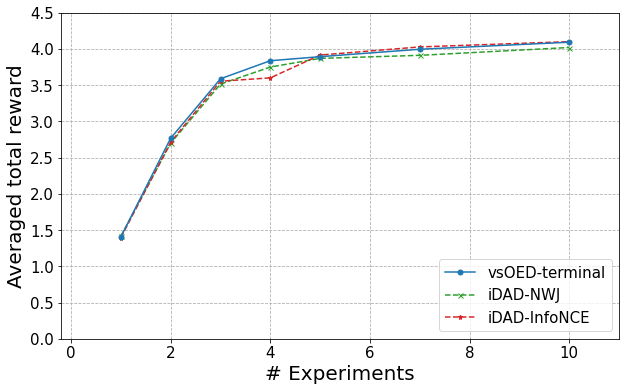

In [61]:
# draw evaluation of each T, compared with limited training
plt.figure(figsize=(10, 6))
markersize = 5
markers = {'gmm':'o', 'NWJ':'x', 'InfoNCE':'*'}
for mode in ['terminal', 'incre']:
    mean = gmm[mode]['mean']
    se = gmm[mode]['se']
    if mode == 'terminal':
        plt.plot(hs, mean, marker=markers['gmm'], markersize=markersize, label=f'vsOED-{mode}', zorder=100)
        plt.fill_between(hs, mean-2*se, mean+2*se, alpha=0.5, zorder=100)
    else:
        plt.plot(hs, mean, marker=markers['gmm'], markersize=markersize, zorder=100, alpha=0.0)
        plt.fill_between(hs, mean-2*se, mean+2*se, alpha=0.0, zorder=100)
for mode in ['NWJ', 'InfoNCE']:
    plt.plot(hs, idad[mode], marker=markers[mode], markersize=markersize, zorder=10, label=f'iDAD-{mode}', ls='--')

plt.legend(fontsize=15, loc=4)
plt.xlabel('# Experiments', fontsize=20)
plt.ylabel('Averaged total reward', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(-0.2, 11)
plt.ylim(0, 4.5)
plt.grid(ls='--')
plt.show()

In [75]:
# pick a mode , id and horizon, and load the data
post_net_type = 'gmm'
mode = 'terminal'
id = 0
h = 5
batch = 0
subfolder = subfolders[post_net_type] + f'/{mode}_id{id}_h{h}/'
eval_data = torch.load(subfolder + f'evaluation_{0}.pt', map_location=device)
params = eval_data['params']
ds_hist = eval_data['ds_hist']
ys_hist = eval_data['ys_hist']
xps_hist = eval_data['xps_hist']
rewards_hist = eval_data['rewards_hist']
vsoed = joblib.load(subfolder + f'/itr_10000.pkl')

Text(0, 0.5, 'stage')

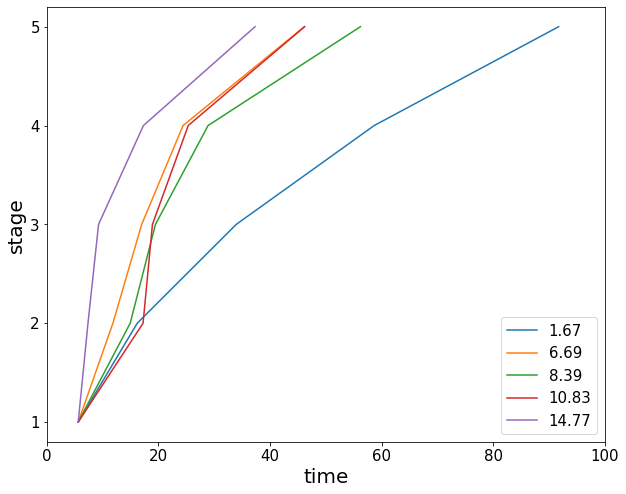

In [76]:
# randomly pick 10 indexes of sample, and draw the designs
# np.random.seed(1369)
idxs = np.random.choice(len(params), 5, replace=False)
xp_hist = xps_hist[idxs].cpu().numpy().reshape(len(idxs), -1)
xp_hist = xp_hist[:, 1:]
param = params[idxs].cpu().numpy()
param = np.exp(param)
r = param[:, 0] / param[:, 1]
idxs_sorted = np.argsort(r)
plt.figure(figsize=(10, 8))
for idx in idxs_sorted:
    plt.plot(xp_hist[idx], np.arange(1, h+1), label=f'{r[idx]:.2f}')
plt.legend(fontsize=15)
plt.yticks(np.arange(1, h+1), fontsize=15)
plt.xticks(fontsize=15)
plt.xlim(0, 100)
plt.xlabel('time', fontsize=20)
plt.ylabel('stage', fontsize=20)

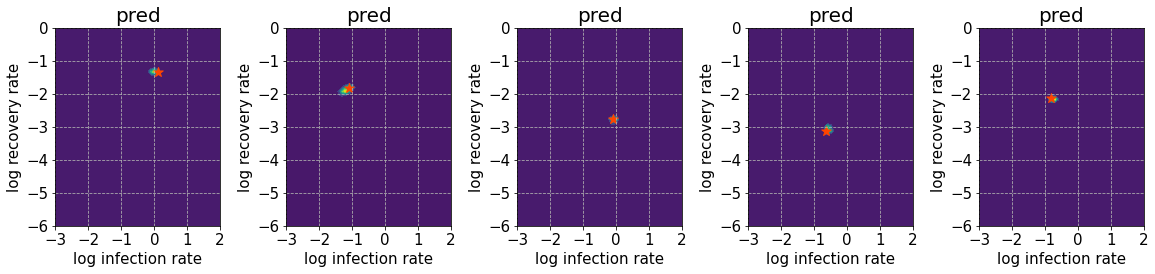

In [75]:
# randomly pick 10 index of samples, and draw the posterior
# np.random.seed(213)
# idxs = np.random.choice(len(params), 10, replace=False)[0]
param_bounds =  [[-3, 2], [-6, 0]]
n_grid = 51
param_grids = [np.linspace(param_bounds[i][0], param_bounds[i][1], n_grid) for i in range(len(param_bounds))]
PARAM = np.meshgrid(*param_grids, indexing='ij')
PARAM = np.array(PARAM)
PARAM = np.moveaxis(PARAM, 0, -1)
PARAM_tensor = torch.from_numpy(np.array(PARAM)).view(-1, len(param_bounds))
net = vsoed.post_approx.poi_post_nets[h - 1][0]

plt.figure(figsize=(20, 8))
for i, idx in enumerate(idxs):
    plt.subplot(2, 5, i + 1, aspect='equal')
    param = params[idx].numpy()
    d_hist = ds_hist[idx].numpy()
    y_hist = ys_hist[idx].numpy()
    xp_hist = xps_hist[idx].numpy()

    X = vsoed.post_approx.form_input(h, ds_hist[idx:idx+1], ys_hist[idx:idx+1])
    X = X.expand(len(PARAM_tensor), -1)
    with torch.no_grad():
        logpost_pred = net(X, PARAM_tensor)
    post_pred = torch.exp(logpost_pred).reshape([n_grid]*len(param_bounds))
    post_pred = post_pred.cpu().numpy()

    X = PARAM[:, :, 0]
    Y = PARAM[:, :, 1]
    post = post_pred
    plt.contourf(X, Y, post)
    plt.scatter(param[0], param[1], s=100, c='orangered', marker='*')
    plt.title('pred', fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel('log infection rate', fontsize=15)
    plt.ylabel('log recovery rate', fontsize=15)
    plt.grid(ls='--')

plt.show()